# Estimation de biens 

In [2]:
# Import libraries 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import median_absolute_error 
import matplotlib.pyplot as plt
import pickle
import requests
import get_files as gf



## 1. downloading files from data.gouv.fr

In [2]:
url_file ="https://www.data.gouv.fr/fr/datasets/r/3004168d-bec4-44d9-a781-ef16f41856a2"
gf.download(url_file)


file already exists


## 2. Loading dataset file

In [30]:
df_val_fonc = pd.read_csv('../data/IN/valeursfoncieres-2019.txt', delimiter = '|',   decimal = ',', encoding='UTF-8')


## 3. Cleaning and Filtering Dataset

In [31]:
# Dispaly ducplicates rows 
duplicate_val_fonc = df_val_fonc[df_val_fonc.duplicated()]

# Drop duplicate rows 
df_val_fonc.drop_duplicates(inplace = True)

# Drop columns and rows  with 100% missing values 
df_val_fonc.dropna(axis = 1, how = 'all', inplace = True)
df_val_fonc.dropna(axis = 0, how = 'all', inplace = True)
# Drop unused columns
df_val_fonc.drop(['No disposition' ,'No Volume','B/T/Q','1er lot','Surface Carrez du 1er lot','2eme lot','Surface Carrez du 2eme lot', 
                  '3eme lot','Surface Carrez du 3eme lot','4eme lot','Surface Carrez du 4eme lot','5eme lot','Prefixe de section',       
                  'Section','Surface Carrez du 5eme lot','Nature culture','Nature culture speciale'], axis = 1, inplace =True)

# Filter rows on Nature Mutation "Vente"
df_val_fonc.drop(df_val_fonc[(df_val_fonc['Nature mutation'] != 'Vente')].index, inplace = True )

# Filter rows on type local "Appartement" 
df_val_fonc.drop(df_val_fonc[(df_val_fonc['Code type local'] != 2)].index, inplace = True )

# Filter rows on valeur fonciere > 10K and < 10 M euros
df_val_fonc.drop(df_val_fonc[(df_val_fonc['Valeur fonciere'] < 10000) | (df_val_fonc['Valeur fonciere'].isna())].index, inplace = True)
df_val_fonc.drop(df_val_fonc[df_val_fonc['Valeur fonciere'] > 10000000].index, inplace = True)

# Filter rows on "surface reelle  bati,Nombre pieces principales"
df_val_fonc.drop(df_val_fonc[(df_val_fonc["Surface reelle bati"] < 9)].index, inplace = True)
df_val_fonc.drop(df_val_fonc[(df_val_fonc["Nombre pieces principales"] == 0)].index, inplace = True)

# df_val_fonc.drop(df_val_fonc[df_val_fonc["Code postal"] < 75000].index, inplace = True)
# df_val_fonc.drop(df_val_fonc[df_val_fonc["Code postal"] > 75021].index, inplace = True)

# Aggregate "surfeace reelle" and "Nombre pieces principales" 
df_apartment = df_val_fonc.groupby(['Date mutation', 'Valeur fonciere','No voie','Voie','Code postal','Commune','Code departement','No plan','Code type local'])['Surface reelle bati','Nombre pieces principales'].sum().reset_index()


# (df_val_fonc.isna().sum() / len(df_val_fonc) * 100).round(2) 
# for col in df_val_fonc.columns:
#     print( col, ' :\t',len(df_val_fonc[df_val_fonc[col].isna()]) / len(df_val_fonc) * 100, ' %')



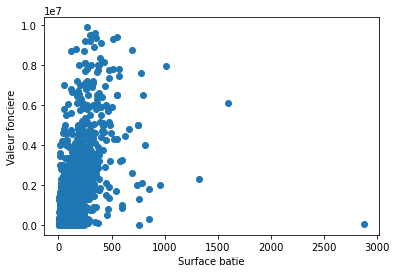

In [14]:
plt.scatter(df_apartment["Surface reelle bati"], df_apartment["Valeur fonciere"])
# plt.plot(df_apartment['Surface reelle bati'],df_apartment["Valeur fonciere"], color ='blue')
plt.xlabel("Surface batie")
plt.ylabel("Valeur fonciere")
plt.show()

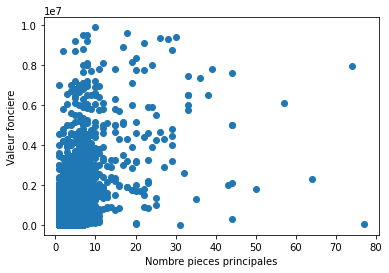

In [15]:
plt.scatter(df_apartment["Nombre pieces principales"], df_apartment["Valeur fonciere"])
plt.xlabel("Nombre pieces principales")
plt.ylabel("Valeur fonciere")
plt.show()

In [32]:

matrice_corr = df_apartment.corr()['Valeur fonciere'].round(2)
matrice_corr
# df_val_fonc.info()

Valeur fonciere              1.00
No voie                     -0.05
Code postal                  0.14
No plan                     -0.08
Code type local               NaN
Surface reelle bati          0.41
Nombre pieces principales    0.37
Name: Valeur fonciere, dtype: float64

## 4. Selecting Features and spliting  the dataset

In [33]:
# Selecting Features
X = df_apartment[['Code postal','Surface reelle bati','Nombre pieces principales']]

# Selecting Target 
y = df_apartment[['Valeur fonciere']]

# Spliting dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=44, shuffle =True)

np.isfinite(X_test).all()




Code postal                  True
Surface reelle bati          True
Nombre pieces principales    True
dtype: bool

In [ ]:
## 5. Fitting random Forest Regressor to the dataset

In [34]:
# applay  Random Forest Regressor
rf = RandomForestRegressor(n_estimators = 50, max_depth = 5, random_state = 33)

# Fitting
rf.fit(X_train, y_train)
rf.fit(X_test, y_test)

# dispaly Modele Score 
rf.score(X_train, y_train)
print("score : ",rf.score(X_test, y_test).round(2) * 100,'%' )

# Saving model using pickle
with open ('rf_model_pickle', 'wb') as f:
    pickle.dump(rf, f)


score :  49.0 %


 ## 6.  Calculating Predict


In [27]:

# Predicting 
y_pred = rf.predict(X_test)
print('Predict Values test : ', y_test[:5].round(2))
print('Predict Values predict : ', y_pred[:5].round(2))



Predict Values test :          Valeur fonciere
142246          94000.0
162232         118000.0
300067         123000.0
62783          120000.0
92674           48000.0
Predict Values predict :  [133731.76 172343.39 662338.06 248808.72 120659.51]


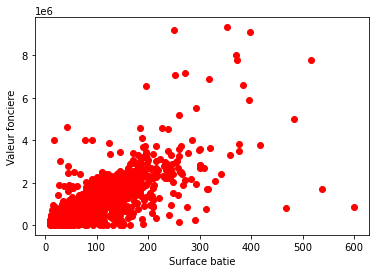

In [24]:
plt.scatter(X_test['Surface reelle bati'], y_test, color = 'red')
# plt.plot(X_train['Surface reelle bati'], rf.predict(X_train), color ='blue')
plt.xlabel("Surface batie")
plt.ylabel("Valeur fonciere")
plt.show()

##  7. Predicting estimation value 

In [28]:

def predict(metre_carre_bati, nb_piece, terrain, code_postal):
    req = {'Code postal':[code_postal],'Surface reelle bati':[metre_carre_bati],'Nombre pieces principales':[nb_piece]}
    df = pd.DataFrame(req, columns = ['Code postal','Surface reelle bati','Nombre pieces principales'])
    print("Given Parameters for Estimation value:\n", df.to_string(index= False)) 
    return (dict(estimation = str(dict(enumerate(rf.predict(df).round(2)))[0]) + ' €')) 

predict(80,4,80,69000)



Given Parameters for Estimation value:
  Code postal  Surface reelle bati  Nombre pieces principales
       69000                   80                          4


{'estimation': '210962.24 €'}

## 8. Calculating Error

In [10]:
#Calculating Mean Absolute Error
m_value = mean_absolute_error(y_test, y_pred, multioutput='uniform_average') 
print('Mean Absolute Error Value is : ', m_value.round(2))
#Calculate mean absolute percentage error (MAPE)
mape = 100 * (m_value / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', accuracy.round(2), '%.')

Mean Absolute Error Value is :  100842.75
Accuracy: Valeur fonciere    14.05
dtype: float64 %.


## 9. Estimation with FastAPI

In [4]:
# Parameters
metre_carre_bati = 80
nb_piece = 3
terrain = 80
code_postal = 75000

query = {"metre_carre_bati" : 80, "nb_piece" :3 , "terrain" : 80, "code_postal" : 69000}

url= " http://localhost:8000/api/estimate/"
reponse = requests.get(url, params =query)
print(reponse.json())


{'estimation': '222866.61 €'}
